In [50]:
source("./Functions/MOCL.R") 
source("./Functions/lambda_selection.R")
source("./Functions/MOCL_wcss.R")
source("./Functions/Adaptive_MAM.R") 

source("./Functions/SKM_gap.R")
source("./Functions/evaluation.R")

library(VarSelLCM) # VarselLCM
library(cluster)     # PAM

library(ggplot2)
library(gridExtra)
library(ggpubr)

library(ggthemes)
library(GGally)
library(RColorBrewer)
library(corrplot)
library(dplyr)
library(pdfCluster)
library(fossil)
options(warn=-1)
library(Rtsne)
library(latex2exp)

# CHR

In [138]:
clu_kk=c(1:4)
mu_or=0.792*(1)
x1=mu_or*2*clu_kk
x2=-mu_or*(1/10)*exp(clu_kk)
x3=mu_or*7*log(clu_kk)

mu_mat_or=cbind(x1,x2,x3)
mu_v_or=apply(mu_mat_or,2,mean)

for(i in 1:4){
    if(i==1){
        m_or=mu_mat_or[i,]%*%t(mu_mat_or[i,])
    }else{
        m_or=m_or+mu_mat_or[i,]%*%t(mu_mat_or[i,])
    }
}
bc_or=sum(diag(m_or/4-mu_v_or%*%t(mu_v_or)))
wc_or=sum(diag(4^(-1)*4*diag(3)))

CHI_or=bc_or/wc_or


###################################
mu_no=5
mu_mat_no=mu_no*diag(4)
mu_v_no=apply(mu_mat_no,2,mean)

for(i in 1:4){
    if(i==1){
        m_no=mu_mat_no[i,]%*%t(mu_mat_no[i,])
    }else{
        m_no=m_no+mu_mat_no[i,]%*%t(mu_mat_no[i,])
    }
}
bc_no=sum(diag(m_no/4-mu_v_no%*%t(mu_v_no)))
wc_no=sum(diag(4^(-1)*4*diag(4)))

CHI_no=bc_no/wc_no


sqrt(CHI_no/CHI_or)

[1] 1.000329

In [132]:
mu_v_no

[1] 1.25 1.25 1.25 1.25

[1] 1.001418

In [52]:
setting_K4<-function(mu_or=1,n_k_lst=c(50,50,50,50),
                                p=20,seed=1234,mu_no=10){
    set.seed(seed)
    K=length(n_k_lst)
    n=sum(n_k_lst)
    
    for(i in 1:K){
        if(i==1){
            clu_k=c(rep(i,n_k_lst[i]))
        }else{
            clu_k=c(clu_k,rep(i,n_k_lst[i]))
        }
    }
    
    mu_1=mu_or*(2*clu_k)
    mu_2=-mu_or*(exp(clu_k)/10)
    mu_3=mu_or*(7*log(clu_k))
    
    
    # Data generation
    x1=mu_1+rnorm(n,0,1)
    x2=mu_2+rnorm(n,0,1)
    x3=mu_3+rnorm(n,0,1)
    
    data_x=scale(cbind(x1,x2,x3))
    
    ############################
    # Data corresponding to nominal clusters
    mu_no_mat=diag(K)
    
    # Nominal cluster generation
    x_no=matrix(0,n,ncol(mu_no_mat))
    p_lst=runif(n,0,1)
    clu_no=p_lst*0
    for(i in 1:K){
        clu_no=clu_no+(p_lst>=((i-1)/K))
    }
    #clu_no
    for(i in 1:nrow(x_no)){
        x_no[i,]=mu_no*mu_no_mat[clu_no[i],]
    }

    for(i in 1:ncol(x_no)){
        x_no[,i]=x_no[,i]+rnorm(nrow(x_no),0,1)
    }

    colnames(x_no)=paste("x_no",1:(ncol(x_no)),sep="_")
    
    ###############################
    # Noise variables
    p_e=p-ncol(data_x)-ncol(x_no)
    noise_mat=nor_minmax(matrix(rnorm(n*p_e,0,1),n,p_e))
    colnames(noise_mat)=paste("noise",1:(ncol(noise_mat)),sep="_")
    
    data=scale(cbind(data_x,x_no,noise_mat))
    
    ## clustering
    kk=K
    pam <- pam(data,kk)
    km <- KMeans_rcpp(data,kk)
    mocl <- MOCL_wcss(Xf=data,k=kk,lambda_seq=seq.default(from=0.001,to=3,length=50),delta=0.01)
    skm <- Sparse_km(data=data,kk=kk,nperms_n=10)
    varsel <- VarSelCluster(data, kk, nbcores = 2, crit.varsel = 'BIC') 
    
    
    # clusters
    cluster_mat=rbind(mocl$cluster,
                     skm$cluster_best,
                     skm$cluster_1sd,
                     fitted(varsel),
                     km$cluster,
                     pam$cluster)
    
    rownames(cluster_mat)=c("MOCL_wcss","SKM_best","SKM_1sd","VSL","KMPP","PAM")
    
    sparse_mat=rbind(t(matrix(apply(abs(mocl$fx),2,sum)>0)),
                    skm$sparse_best,skm$sparse_1sd,
                     slot(slot(varsel,'model'),'omega'))
    
    rownames(sparse_mat)=c("MOCL","SKM_best","SKM_1sd","VSL")
    
    rand_mat=t(matrix(c(rand.index(clu_k,mocl$cluster),
                         rand.index(clu_k,skm$cluster_best),
                         rand.index(clu_k,skm$cluster_1sd),
                         rand.index(clu_k,fitted(varsel)),
                         rand.index(clu_k,km$cluster),
                         rand.index(clu_k,pam$cluster))))
    
    colnames(rand_mat)=c("MOCL","SKM_best","SKM_1sd","VSL","KMPP","PAM")
    kendall=cor(clu_k,mocl$cluster,method="kendall")
    
    
    if(p==ncol(data_x)){
        TP_FP_mat=cbind(apply(sparse_mat[,c(1:ncol(data_x))],1,mean),
                        c(rep(0,nrow(sparse_mat))))
    }
    if(p>ncol(data_x)){
        TP_FP_mat=cbind(apply(sparse_mat[,c(1:ncol(data_x))],1,mean),
                    apply(sparse_mat[,c((ncol(data_x)+1):ncol(sparse_mat))],1,mean))
    }
    
    rand_no=rand.index(clu_k,clu_no)
    return(list(cluster=clu_k,clu_no=clu_no,rand_no=rand_no,cluster_mat=cluster_mat,data=data,mocl_lam=mocl$lambda_sel_mat,
                sparse_mat=sparse_mat,rand_mat=rand_mat,TP_FP_mat=TP_FP_mat,kendall=kendall,
                fx_mocl=mocl$fx,
                coef_mocl=mocl$coef,
                weight_skm=skm$weigth_best,weight_skm_1sd=skm$weigth_1sd))
}

## Clustering

In [53]:
iter_n=100

In [54]:
ss=43
set.seed(ss)
seed_r=round(runif(25000,1,30000))
models_0=list()
models_1=list()
models_2=list()
models_3=list()
models_4=list()
models_5=list()

Sys.time()
for(i in 1:iter_n){
    seed_rr=seed_r[120*i+22]
    models_0[[i]]=setting_K4(mu_or=0.792*(1/0.1),mu_no=5,seed=seed_rr)  
}
Sys.time()
for(i in 1:iter_n){
    seed_rr=seed_r[120*i+22]
    models_1[[i]]=setting_K4(mu_or=0.792*(1/0.3),mu_no=5,seed=seed_rr)  
}
Sys.time()
for(i in 1:iter_n){
    seed_rr=seed_r[120*i+21]
    models_2[[i]]=setting_K4(mu_or=0.792*(1/0.5),mu_no=5,seed=seed_rr)  
}
Sys.time()
for(i in 1:iter_n){
    seed_rr=seed_r[120*i+224]
    models_3[[i]]=setting_K4(mu_or=0.792*(1/0.7),mu_no=5,seed=seed_rr)  
}
Sys.time()
for(i in 1:iter_n){
    seed_rr=seed_r[120*i+25]
    models_4[[i]]=setting_K4(mu_or=0.792*(1/0.9),mu_no=5,seed=seed_rr)   
}
Sys.time()
for(i in 1:iter_n){
    seed_rr=seed_r[120*i+223]
    models_5[[i]]=setting_K4(mu_or=0.792*(1/1.1),mu_no=5,seed=seed_rr)  
}
Sys.time()



In [55]:
ss=553
set.seed(ss)
seed_r=round(runif(25000,1,30000))

models_6=list()
models_7=list()
models_8=list()
models_9=list()
models_10=list()

Sys.time()
for(i in 1:iter_n){
    seed_rr=seed_r[120*i+22]
    models_6[[i]]=setting_K4(mu_or=0.792*(1/1.3),mu_no=5,seed=seed_rr)  
}
Sys.time()
for(i in 1:iter_n){
    seed_rr=seed_r[120*i+21]
    models_7[[i]]=setting_K4(mu_or=0.792*(1/1.5),mu_no=5,seed=seed_rr)  
}
Sys.time()
for(i in 1:iter_n){
    seed_rr=seed_r[120*i+224]
    models_8[[i]]=setting_K4(mu_or=0.792*(1/1.7),mu_no=5,seed=seed_rr)  
}
Sys.time()
for(i in 1:iter_n){
    seed_rr=seed_r[120*i+25]
    models_9[[i]]=setting_K4(mu_or=0.792*(1/1.9),mu_no=5,seed=seed_rr)   
}
Sys.time()
for(i in 1:iter_n){
    seed_rr=seed_r[1*i+3]
    models_10[[i]]=setting_K4(mu_or=0.792*(1/2.1),mu_no=5,seed=seed_rr)  
}
Sys.time()

# Results

In [57]:
mm_lst=list()
mm_lst[[1]]=models_0
mm_lst[[2]]=models_1
mm_lst[[3]]=models_2
mm_lst[[4]]=models_3
mm_lst[[5]]=models_4
mm_lst[[6]]=models_5
mm_lst[[7]]=models_6
mm_lst[[8]]=models_7
mm_lst[[9]]=models_8
mm_lst[[10]]=models_9
mm_lst[[11]]=models_10

In [58]:
for(i in 1:length(mm_lst)){
    if(i==1){
        rand_mat=round(rand_summary(mm_lst[[i]])$rand_mean,3)
    }else{
        rand_mat=rbind(rand_mat,round(rand_summary(mm_lst[[i]])$rand_mean,3))
    }
}

for(i in 1:length(mm_lst)){
    if(i==1){
        rand_no_mat=round(rand_no_summary(mm_lst[[i]])$rand_no_mean,3)
    }else{
        rand_no_mat=rbind(rand_no_mat,round(rand_no_summary(mm_lst[[i]])$rand_no_mean,3))
    }
}

In [59]:
var_acc<-function(models,index=c(1,2,3)){
    for(i in 1:length(models)){
        if(i==1){
            acc=apply(models[[i]]$sparse_mat[,index],1,mean)
        }else{
            acc=rbind(acc,apply(models[[i]]$sparse_mat[,index],1,mean))
        }
    }
    acc_mean=apply(acc,2,mean)
    return(acc_mean)
}

for(i in 1:length(mm_lst)){
    if(i==1){
        tp_ord=var_acc(models=mm_lst[[i]],index=c(1,2,3))
        tp_nom=var_acc(models=mm_lst[[i]],index=c(4,5,6,7))
        tp_noi=var_acc(models=mm_lst[[i]],index=c(8:20))
    }else{
        tp_ord=rbind(tp_ord,var_acc(models=mm_lst[[i]],index=c(1,2,3)))
        tp_nom=rbind(tp_nom,var_acc(models=mm_lst[[i]],index=c(4:7)))
        tp_noi=rbind(tp_noi,var_acc(models=mm_lst[[i]],index=c(8:20)))
    }
}




# Plots

In [60]:
skm_var=-2 # 
rand_mat=rand_mat[,skm_var]
rand_no_mat=rand_no_mat[,skm_var]

tp_ord=tp_ord[,skm_var]
tp_nom=tp_nom[,skm_var]
tp_noi=tp_noi[,skm_var]

## Rand index

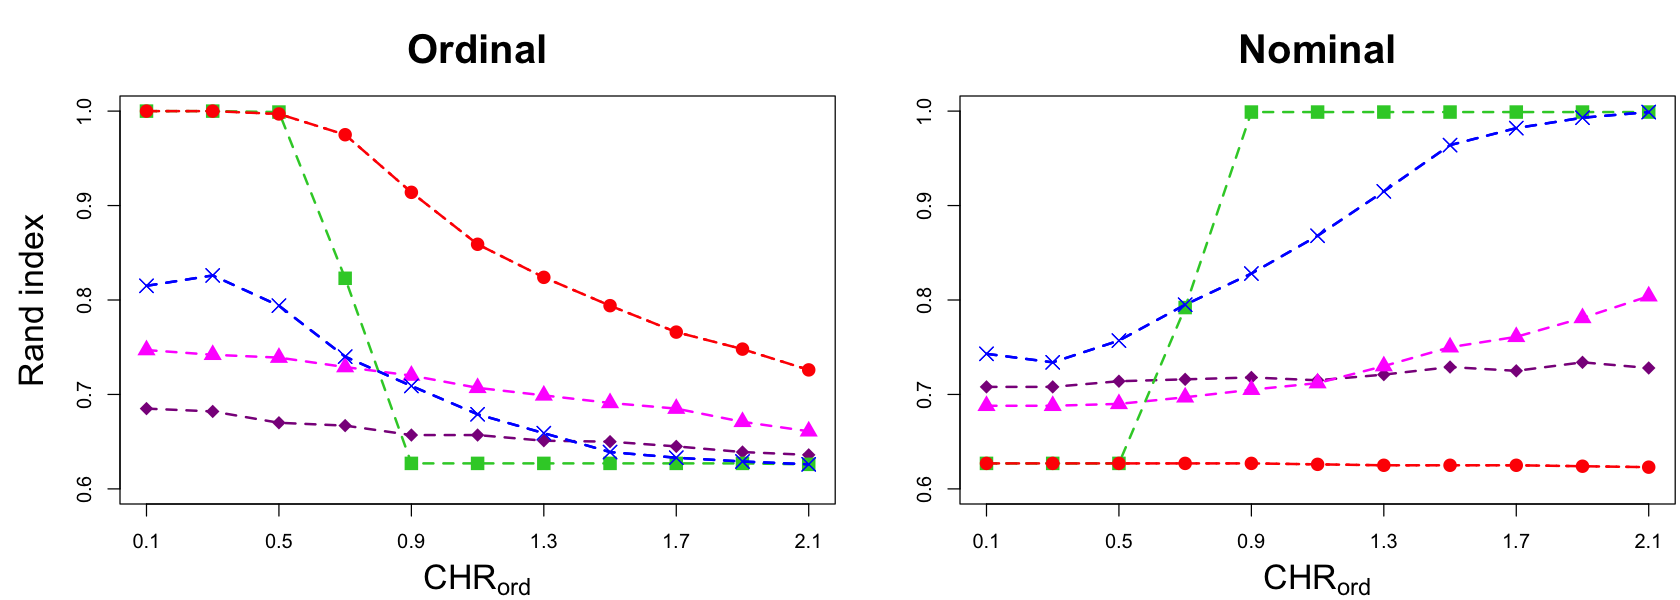

In [64]:
CHR=c(0:10)/5+0.1

options(repr.plot.width = 14, repr.plot.height = 5)
par(mfrow=c(1,2))
par(mar=c(4,5,4,0.2))



pch_lst=c(16,4.2,15,17,18)
col_lst=c("red","blue","Lime Green","magenta","Dark Magenta")

###############################
# rand index

plot(CHR,rand_mat[,1],type="l",xlim=c(min(CHR),max(CHR)),ylim=c(0.6,1),col=col_lst[1],lwd=2,lty=3,xaxt='n',
    xlab=TeX("$CHR_{ord}$"),ylab="Rand index",main="Ordinal",cex.main=2,cex.lab=1.7)
axis(1,at=c(0.1,0.5,0.9,1.3,1.7,2.1))
#TeX("$\\hat{m}_j$")
for(i in c(5:1,2)){
    lines(CHR,rand_mat[,i],type="l",ylim=c(0,1),col=col_lst[i],lwd=2,lty=2)
    points(CHR,rand_mat[,i],pch=pch_lst[i],col=col_lst[i],cex=1.5,cex.lab=1.5)
}

###############################
# rand no index

plot(CHR,rand_no_mat[,1],type="l",xlim=c(min(CHR),max(CHR)),ylim=c(0.6,1),col=col_lst[1],lwd=2,lty=3,xaxt='n',
    xlab=TeX("$CHR_{ord}$"),ylab="",main="Nominal",cex.main=2,cex.lab=1.7)
axis(1,at=c(0.1,0.5,0.9,1.3,1.7,2.1))

for(i in c(5:1,2)){
    lines(CHR,rand_no_mat[,i],type="l",ylim=c(0,1),col=col_lst[i],lwd=2,lty=2)
    points(CHR,rand_no_mat[,i],pch=pch_lst[i],col=col_lst[i],cex=1.5)
}

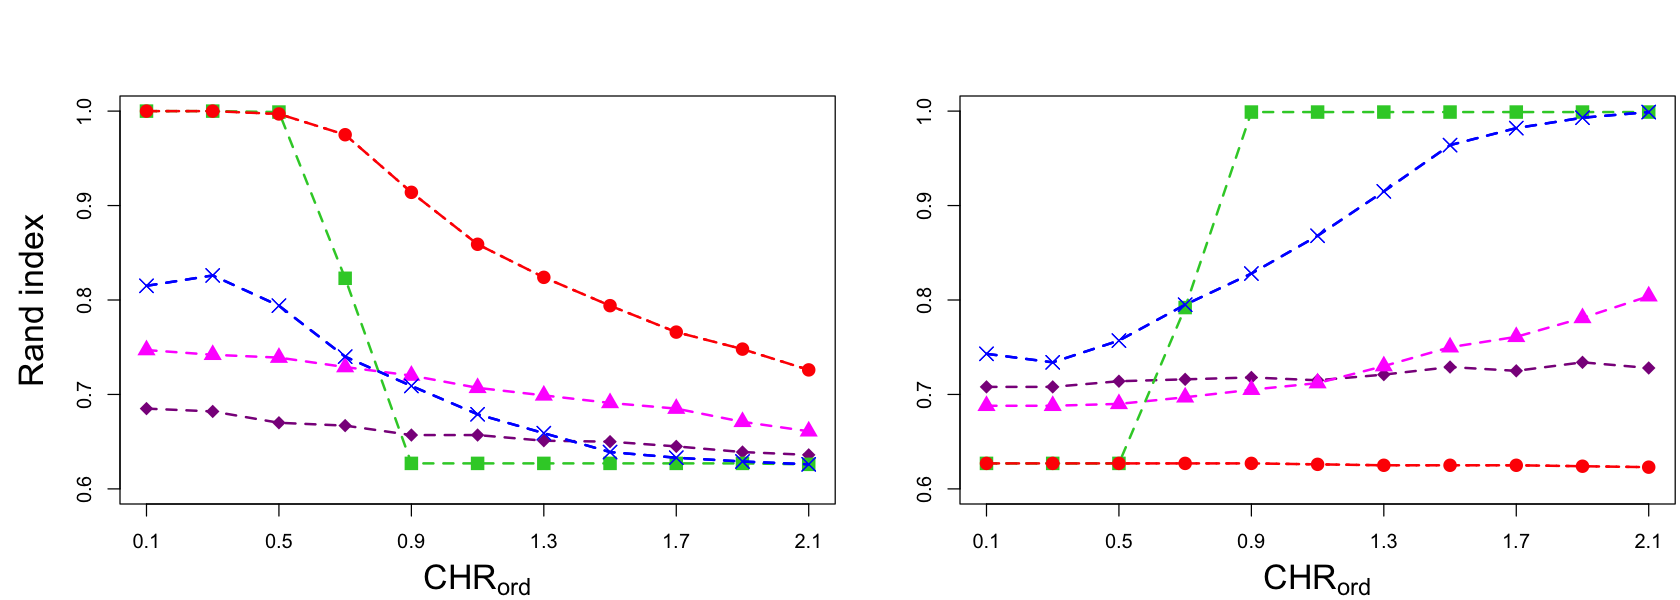

In [65]:
CHR=c(0:10)/5+0.1

options(repr.plot.width = 14, repr.plot.height = 5)
par(mfrow=c(1,2))
par(mar=c(4,5,4,0.2))



pch_lst=c(16,4.2,15,17,18)
col_lst=c("red","blue","Lime Green","magenta","Dark Magenta")

###############################
# rand index

plot(CHR,rand_mat[,1],type="l",xlim=c(min(CHR),max(CHR)),ylim=c(0.6,1),col=col_lst[1],lwd=2,lty=3,xaxt='n',
    xlab=TeX("$CHR_{ord}$"),ylab="Rand index",main="",cex.main=2,cex.lab=1.7)
axis(1,at=c(0.1,0.5,0.9,1.3,1.7,2.1))
#TeX("$\\hat{m}_j$")
for(i in c(5:1,2)){
    lines(CHR,rand_mat[,i],type="l",ylim=c(0,1),col=col_lst[i],lwd=2,lty=2)
    points(CHR,rand_mat[,i],pch=pch_lst[i],col=col_lst[i],cex=1.5,cex.lab=1.5)
}

###############################
# rand no index

plot(CHR,rand_no_mat[,1],type="l",xlim=c(min(CHR),max(CHR)),ylim=c(0.6,1),col=col_lst[1],lwd=2,lty=3,xaxt='n',
    xlab=TeX("$CHR_{ord}$"),ylab="",main="",cex.main=2,cex.lab=1.7)
axis(1,at=c(0.1,0.5,0.9,1.3,1.7,2.1))

for(i in c(5:1,2)){
    lines(CHR,rand_no_mat[,i],type="l",ylim=c(0,1),col=col_lst[i],lwd=2,lty=2)
    points(CHR,rand_no_mat[,i],pch=pch_lst[i],col=col_lst[i],cex=1.5)
}

## Variable selection

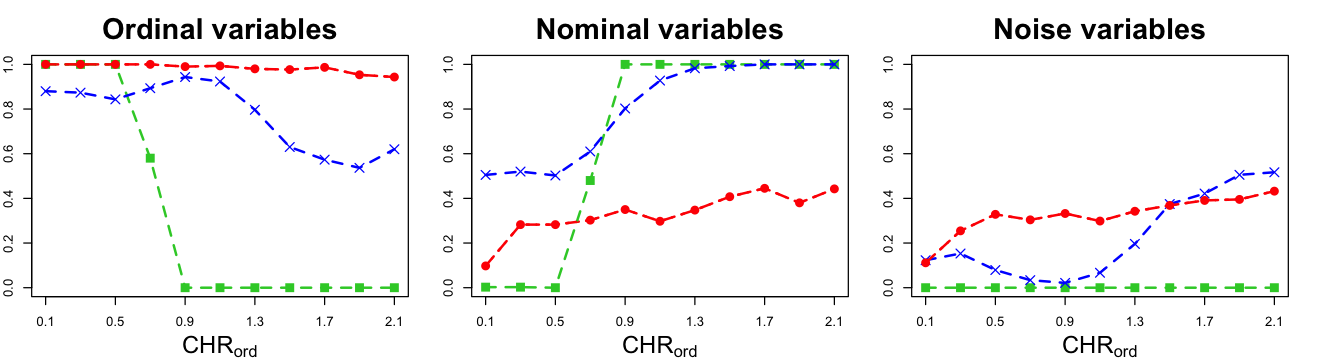

In [62]:
options(repr.plot.width = 11, repr.plot.height = 3)
par(mfrow=c(1,3))
par(mar=c(4,2,3.5,2))


###############################
# Tp of ordinal variables

plot(CHR,tp_ord[,1],type="l",xlim=c(min(CHR),max(CHR)),ylim=c(0,1),col=col_lst[1],lwd=2,lty=3,xaxt='n',
    xlab=TeX("$CHR_{ord}$"),ylab="",main="Ordinal variables",cex.main=2.2,cex.lab=1.8)
axis(1,at=c(0.1,0.5,0.9,1.3,1.7,2.1))

for(i in c(3:1)){
    lines(CHR,tp_ord[,i],type="l",ylim=c(0,1),col=col_lst[i],lwd=2,lty=2)
    points(CHR,tp_ord[,i],pch=pch_lst[i],col=col_lst[i],cex=1.5)
}

###############################
# Tp of nominal variables

plot(CHR,tp_nom[,1],type="l",xlim=c(min(CHR),max(CHR)),ylim=c(0,1),col=col_lst[1],lwd=2,lty=3,xaxt='n',
    xlab=TeX("$CHR_{ord}$"),ylab="",main="Nominal variables",cex.main=2.2,cex.lab=1.8)
axis(1,at=c(0.1,0.5,0.9,1.3,1.7,2.1))

for(i in c(3:1)){
    lines(CHR,tp_nom[,i],type="l",ylim=c(0,1),col=col_lst[i],lwd=2,lty=2)
    points(CHR,tp_nom[,i],pch=pch_lst[i],col=col_lst[i],cex=1.5)
}
###############################
# Tp of noise variables

plot(CHR,tp_noi[,1],type="l",xlim=c(min(CHR),max(CHR)),ylim=c(0,1),col=col_lst[1],lwd=2,lty=3,xaxt='n',
    xlab=TeX("$CHR_{ord}$"),ylab="",main="Noise variables",cex.main=2.2,cex.lab=1.8)
axis(1,at=c(0.1,0.5,0.9,1.3,1.7,2.1))

for(i in c(3:1)){
    lines(CHR,tp_noi[,i],type="l",ylim=c(0,1),col=col_lst[i],lwd=2,lty=2)
    points(CHR,tp_noi[,i],pch=pch_lst[i],col=col_lst[i],cex=1.5)
}

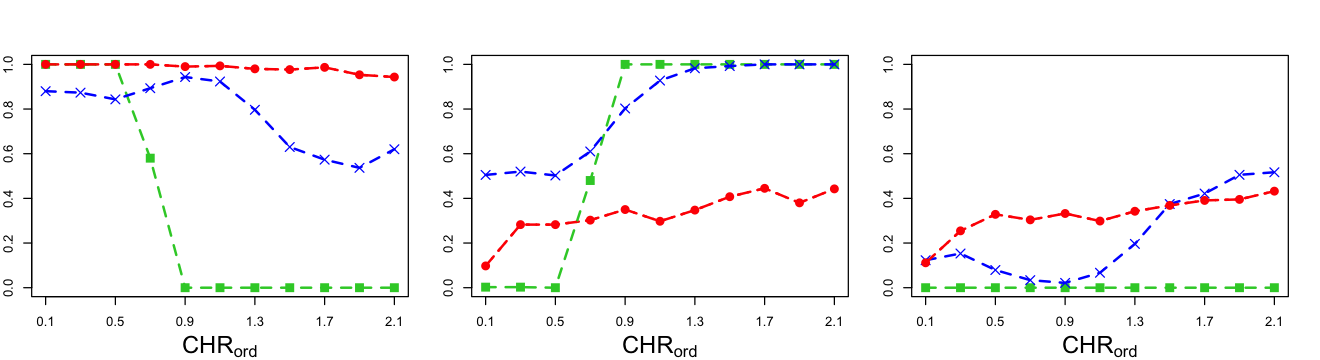

In [63]:
options(repr.plot.width = 11, repr.plot.height = 3)
par(mfrow=c(1,3))
par(mar=c(4,2,3.5,2))


###############################
# Tp of ordinal variables

plot(CHR,tp_ord[,1],type="l",xlim=c(min(CHR),max(CHR)),ylim=c(0,1),col=col_lst[1],lwd=2,lty=3,xaxt='n',
    xlab=TeX("$CHR_{ord}$"),ylab="",main="",cex.main=2.2,cex.lab=1.8)
axis(1,at=c(0.1,0.5,0.9,1.3,1.7,2.1))

for(i in c(3:1)){
    lines(CHR,tp_ord[,i],type="l",ylim=c(0,1),col=col_lst[i],lwd=2,lty=2)
    points(CHR,tp_ord[,i],pch=pch_lst[i],col=col_lst[i],cex=1.5)
}

###############################
# Tp of nominal variables

plot(CHR,tp_nom[,1],type="l",xlim=c(min(CHR),max(CHR)),ylim=c(0,1),col=col_lst[1],lwd=2,lty=3,xaxt='n',
    xlab=TeX("$CHR_{ord}$"),ylab="",main="",cex.main=2.2,cex.lab=1.8)
axis(1,at=c(0.1,0.5,0.9,1.3,1.7,2.1))

for(i in c(3:1)){
    lines(CHR,tp_nom[,i],type="l",ylim=c(0,1),col=col_lst[i],lwd=2,lty=2)
    points(CHR,tp_nom[,i],pch=pch_lst[i],col=col_lst[i],cex=1.5)
}
###############################
# Tp of noise variables

plot(CHR,tp_noi[,1],type="l",xlim=c(min(CHR),max(CHR)),ylim=c(0,1),col=col_lst[1],lwd=2,lty=3,xaxt='n',
    xlab=TeX("$CHR_{ord}$"),ylab="",main="",cex.main=2.2,cex.lab=1.8)
axis(1,at=c(0.1,0.5,0.9,1.3,1.7,2.1))

for(i in c(3:1)){
    lines(CHR,tp_noi[,i],type="l",ylim=c(0,1),col=col_lst[i],lwd=2,lty=2)
    points(CHR,tp_noi[,i],pch=pch_lst[i],col=col_lst[i],cex=1.5)
}